# Segment-Averaged Speed Simulation Test

Here we test feeding LOGIOS segment-averaged drive cycle data into FASTSim, rather than the raw drive-cycle data.  

That is, given some raw (recorded at 1-second granularity) drive cycle data (timeseries data of speed and gradient), produce 1-second granularity timeseries where the speed and gradient values are averaged over X-meter segments (segment length X could be 50, 100, whatever). 

Then compare how the simulations for the raw and segment-averaged drive cycles compare.

Motivation: The segment-averaged drive cycles are the sort of data we'll have access too at scale. We'll assemble drive cycles from bus route shapefiles and waze averaged speed data. So it'll be useful to see how well that sort of segment-averaged drive cycle can approximate a experimentally-recordded raw drive cycle recorded with a sensor on a bus.

In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import namedtuple

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

In [3]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

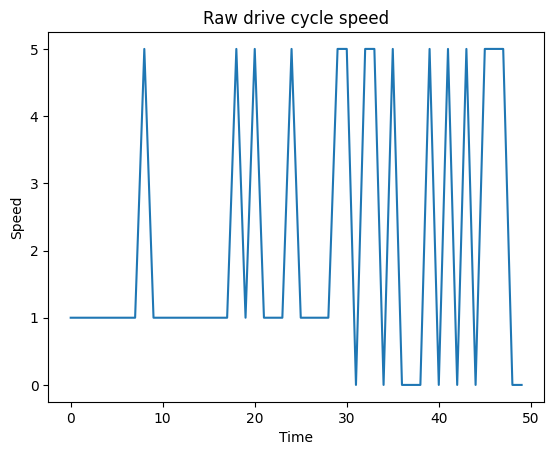

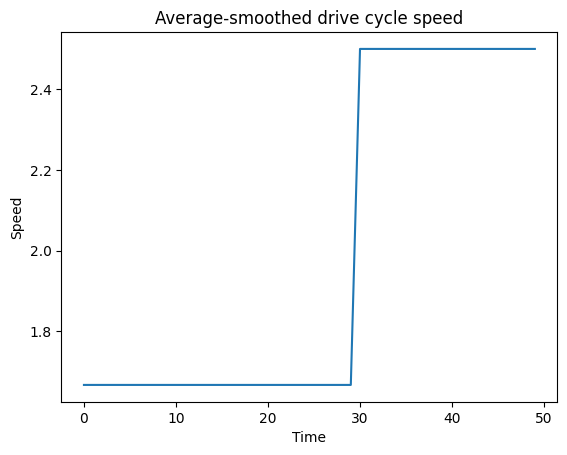

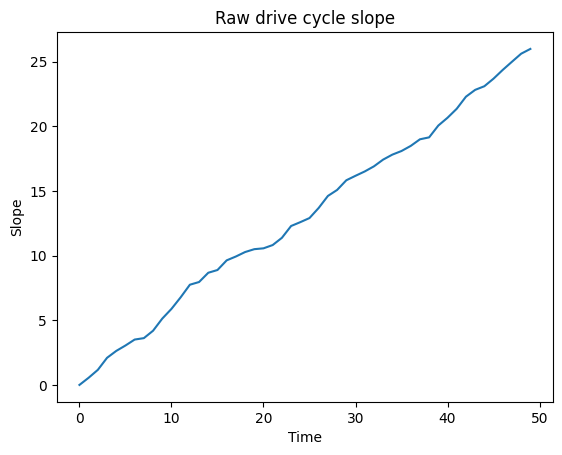

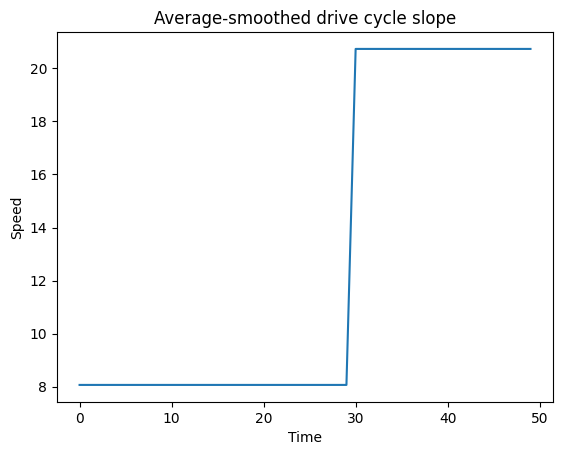

In [54]:
# TEST
import random

n = 50 # 50 seconds

# Generate 50 seconds of speed measurements
first_50m = np.concatenate((np.repeat(5,5), np.repeat(1,25)))   # 50 meters in 30 secondds
random.shuffle(first_50m)
second_50m = np.concatenate((np.repeat(5,10), np.repeat(0,10))) # 50 meters in 20 seconds
random.shuffle(second_50m)

random_slopes = np.zeros(n)
for i in range(1, n):
    random_slopes[i] = random_slopes[i-1] + random.random()

# Create a test drive cycle data frame
data = {
    'Time': range(50),
    'Speed': np.concatenate((first_50m, second_50m)),
    'Slope': random_slopes,
}

df = pd.DataFrame(data)
avg_df = df.copy()
# print(df)

# Timepoints when increments of 50 meters have been reached
# Starts at zero, then each element marks the end point (exclusive) of a range of time
dx_breakpoints = [0, 30, 50]
# avg_speeds = np.full(len(dx_breakpoints)-1, np.nan)
# Calculate average speed and slope for each 50 meter segment
for i in range(len(dx_breakpoints)-1):
    start, end = dx_breakpoints[i], dx_breakpoints[i+1]
    r = range(start, end)
    avg_speed = df.Speed[r.start:r.stop].mean()
    avg_slope = df.Slope[r.start:r.stop].mean()
    avg_df.Speed[r.start:r.stop] = np.array([avg_speed for i in r])
    avg_df.Slope[r.start:r.stop] = np.array([avg_slope for i in r])
    
#print(avg_speeds)
#print(5*(5/30) + 1*(25/30))
assert np.all(np.isclose(avg_df.Speed[0:30], [5*(5/30) + 1*(25/30) for i in range(30)]))
assert np.all(avg_df.Speed[30:50] == [2.5 for i in range(20)])

plt.plot(df['Time'], df['Speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Raw drive cycle speed')
plt.show()

plt.plot(avg_df['Time'], avg_df['Speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Segment-Averaged drive cycle speed')
plt.show()

plt.plot(df['Time'], df['Slope'])
plt.xlabel('Time')
plt.ylabel('Slope')
plt.title('Raw drive cycle slope')
plt.show()

plt.plot(avg_df['Time'], avg_df['Slope'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Segment-Averaged drive cycle slope')
plt.show()

In [ ]:
# INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
# routes_and_days = {
#     'AB03': {
#         # Days when drive cycle data was collected for this route
#         # 'days': ['0520', '0521', '0527', '0531'],
#         'days': ['0520'], # TODO
         
#         # LOGIOS-predicted range along this route from 100% to 0% SOC.
#         # Extracted from LOGIOS 'Energy Available' graph in deliverable 4 report. e.g. Fig. 4.
#         'rangeKm': 221.18,
#     },
#     # TODO add the other routes and days
# }

# # Simulate all distinct (route,day) drive cycles and store results
# results = {}
# for route_name in routes_and_days.keys():
#     route = routes_and_days[route_name]
#     for day in route['days']:
#         print(f'Processing route {route_name}, day {day}...')
#         drive_cycle_path = Path(INPUT_PATH) / route_name / day
#         output = utils.run_fastsim(drive_cycle_path, bus_jit)
#         output['fastsim_range'] = output['rangeKm']
#         output['logios_range'] = route['rangeKm']
#         results[f'{route_name}/{day}'] = output

In [90]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()
# Get FASTSim output for comparison
fs_output = utils.run_fastsim(path, bus_jit)
fs_df = pd.DataFrame.from_dict(fs_output)

Time to run simulation: 2.49e+00 s


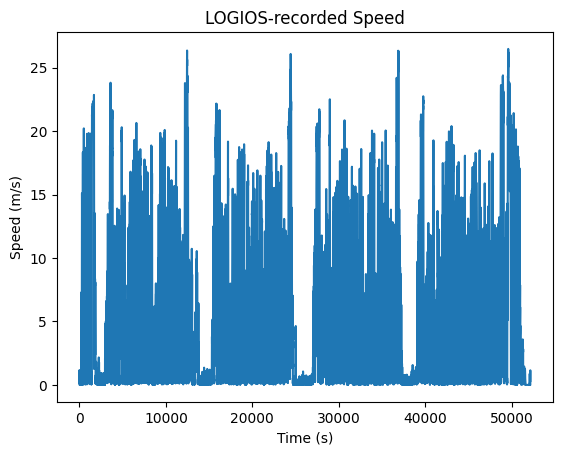

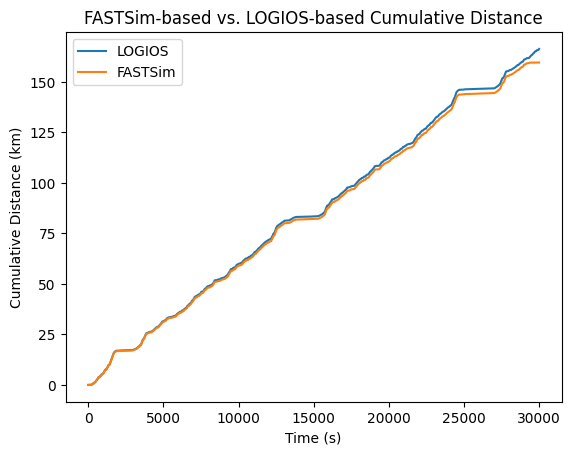

There are 5807 50-meter segments in this 290.3 km route


In [131]:
# Test detecting dx_breakpoints from drive cycle

# Load LOGIOS drive cycles
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
num_segments = None
path = Path(INPUT_PATH) / 'AB03' / '0520'
sorted_dc_files = sorted(path.iterdir(), key=lambda f: str(f))

# Concatenate the drive cycle dataframes into the full day's drive cycle
cyc_dfs = [pd.read_csv(file) for file in sorted_dc_files[0:num_segments]]
cyc_df = pd.concat(cyc_dfs, axis=0)

# LOGIOS speed measurements are km/h. Convert to m/s for fastsim
logios_speed_mps = cyc_df.Speed * 1000/3600

# Overwrite index and time to be monotonically increasing. The individual cycle files were each
# re-indexed to 0 by LOGIOS.
cyc_df.Time[:] = range(0,len(cyc_df.Time))
cyc_df.set_index('Time', inplace=True)

# plt.plot(fs_df['time'],fs_df['speed'])
# plt.xlabel('Time')
# plt.ylabel('Speed (m/s)')
# plt.title('FASTSim-calculated Speed')
# plt.show()

plt.plot(cyc_df.index, logios_speed_mps)
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('LOGIOS-recorded Speed')
plt.show()

# Confirmed that FASTSim's speed series is an exact match of LOGIOS'
assert np.all(np.isclose(fs_df['speed'], cyc_df.Speed * 1000/3600))

# TODO
# [✅] Calculate cumulative distance based on speed measurements
    # [[✅]] Validate this against the distance measurments in LOGIOS df
# [ ] Detect breakpoints

# Calculate CumDist
dx = logios_speed_mps # Speed in meters per second
# Each speed measurement is actually a distance measurement bc mps * 1s = mps
cumDistKm = dx.cumsum() / 1000

r = range(0, 30000)
plt.plot(cyc_df.index[r.start:r.stop], cumDistKm[r.start:r.stop], label='LOGIOS')
plt.plot(fs_df['time'][r.start:r.stop], fs_df['cumDistKm'][r.start:r.stop], label='FASTSim')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Distance (km)')
plt.title('FASTSim-based vs. LOGIOS-based Cumulative Distance')
plt.legend()
plt.show()

# Detect breakpoints
segment_dist_m = 50 # Break route into 50-meter segments

# A series of (time, cumDist) tuples marking the segment starts
Segment = namedtuple('Segment', ['time', 'cumDist'])
dx_breakpoints = [Segment(0,0)]
for t in range(1, len(cyc_df)):
    if cumDistKm.iloc[t] >= len(dx_breakpoints) * segment_dist_m / utils.m_per_km:
        dx_breakpoints.append(Segment(t, cumDistKm.iloc[t]))
print(f'There are {len(dx_breakpoints)} {segment_dist_m}-meter segments in this {cumDistKm.iloc[-1]:.01f} km route')

# TODO: Histogram of the amount of time per segment

# Create segment-averaged drive cycle
avg_df = cyc_df.copy()
for i in range(len(dx_breakpoints)-1):
    start, end = dx_breakpoints[i].time, dx_breakpoints[i+1].time
    r = range(start, end)
    avg_speed = cyc_df.Speed[r.start:r.stop].mean()
    avg_slope = cyc_df.Slope[r.start:r.stop].mean()
    avg_df.Speed[r.start:r.stop] = np.array([avg_speed for i in r])
    avg_df.Slope[r.start:r.stop] = np.array([avg_slope for i in r])

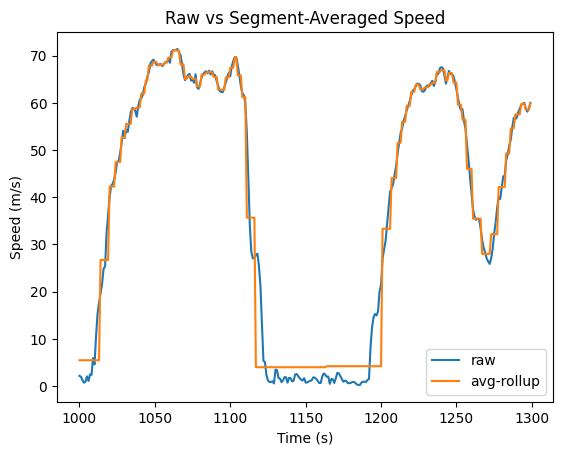

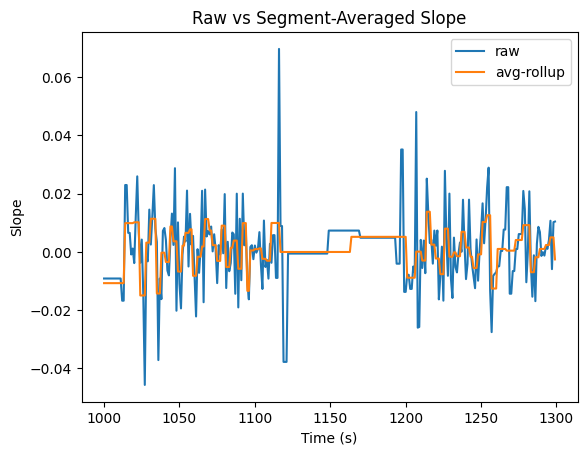

In [141]:
time_range = range(1000, 1000 + 5*60) # 5 minutes
raw_window = cyc_df[time_range.start:time_range.stop]
avg_window = avg_df[time_range.start:time_range.stop]

plt.plot(raw_window.index, raw_window['Speed'], label='raw')
plt.plot(avg_window.index, avg_window['Speed'], label='avg-rollup')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Raw vs Segment-Averaged Speed')
plt.legend()
plt.show()

plt.plot(raw_window.index, raw_window['Slope'], label='raw')
plt.plot(avg_window.index, avg_window['Slope'], label='avg-rollup')
plt.xlabel('Time (s)')
plt.ylabel('Slope')
plt.title('Raw vs Segment-Averaged Slope')
plt.legend()
plt.show()

# TODO zoom in on a smaller section and compare the average-smoothed vs raw cycle speeds and slopes

# Compare FASTSim output for Raw vs. Segment-Averaged drive cycle